In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import helper

data_dir = './faces'
img_path_list = glob(os.path.join(data_dir,'*.jpg'))



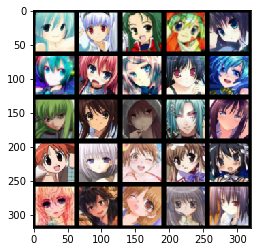

In [2]:

show_n_images = 25
IMG_SIZE=64


anime_images = helper.get_batch(img_path_list[:show_n_images], IMG_SIZE, IMG_SIZE, 'RGB')
plt.imshow(helper.images_square_grid(anime_images, 'RGB'))

In [3]:
tf.test.is_gpu_available()

True

In [4]:
def model_inputs(img_width , img_height , img_channel , z_dim):
    input_real_img = tf.placeholder(tf.float32,(None,img_width,img_height,img_channel),'input_real_img')
    z_vector = tf.placeholder(tf.float32,(None,z_dim),'z_vector')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real_img,z_vector,learning_rate
    

In [70]:
def conv2d(images,conv_dim,kernel_size=5,strides=2,padding='same',is_training = True):
    
    x = tf.layers.conv2d(images,conv_dim,kernel_size,strides=strides,padding=padding,use_bias=False)
    x = tf.layers.batch_normalization(x,training=is_training)
    
    return x

In [62]:
def deconv2d(images,conv_dim,kernel_size=5,strides=2,padding='same',is_training = True,activation='sigmoid'):
    alpha=0.2
    x = tf.layers.conv2d_transpose(images,conv_dim,kernel_size,strides=strides,padding=padding,use_bias=False)
    x = tf.layers.batch_normalization(x,training=is_training)
    x = tf.maximum(alpha * x, x)
    
    return x

In [72]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer is 64x64x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 32x32x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 32x32x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 16*16*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [73]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 16*16*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 16, 16, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 16x16x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 32x32x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 64x64x3 now
        
        out = tf.tanh(logits)
        
        return out

In [74]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    



In [75]:
def model_opt(d_loss,g_loss,learning_rate,beta1):
    
#     t_vars = tf.trainable_variables()
#     d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
#     g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_vars = [ var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator') ]
    g_vars = [ var for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=beta1).minimize(d_loss,var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=beta1).minimize(g_loss,var_list = g_vars)
        
    return d_train_opt , g_train_opt
    

In [76]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

In [77]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    ### Build GAN
    
    # Define Model_Inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Define Model_Loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Define Model_Opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    ### Training
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                batch_counter += 1
                
                # Need to first scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                
                
                if batch_counter % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(e+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                
                
                if batch_counter % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

Epoch 1/5 - Batch 10/1039:  Discriminator loss = 2.5820  Generator loss = 0.3629
Epoch 1/5 - Batch 20/1039:  Discriminator loss = 4.3263  Generator loss = 5.9425
Epoch 1/5 - Batch 30/1039:  Discriminator loss = 2.4584  Generator loss = 3.3767
Epoch 1/5 - Batch 40/1039:  Discriminator loss = 4.6047  Generator loss = 4.1767
Epoch 1/5 - Batch 50/1039:  Discriminator loss = 4.2752  Generator loss = 0.0322
Epoch 1/5 - Batch 60/1039:  Discriminator loss = 2.6942  Generator loss = 0.1498
Epoch 1/5 - Batch 70/1039:  Discriminator loss = 1.9323  Generator loss = 0.3347
Epoch 1/5 - Batch 80/1039:  Discriminator loss = 1.5235  Generator loss = 2.5400
Epoch 1/5 - Batch 90/1039:  Discriminator loss = 2.8873  Generator loss = 0.1159
Epoch 1/5 - Batch 100/1039:  Discriminator loss = 4.1481  Generator loss = 0.0390


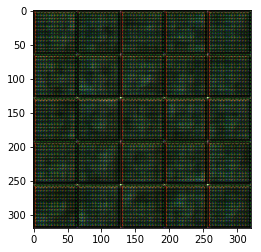

Epoch 1/5 - Batch 110/1039:  Discriminator loss = 4.3503  Generator loss = 0.3406
Epoch 1/5 - Batch 120/1039:  Discriminator loss = 3.8725  Generator loss = 0.4718
Epoch 1/5 - Batch 130/1039:  Discriminator loss = 3.1408  Generator loss = 0.1118
Epoch 1/5 - Batch 140/1039:  Discriminator loss = 2.2811  Generator loss = 0.2401
Epoch 1/5 - Batch 150/1039:  Discriminator loss = 1.7875  Generator loss = 1.1020
Epoch 1/5 - Batch 160/1039:  Discriminator loss = 1.9060  Generator loss = 0.7166
Epoch 1/5 - Batch 170/1039:  Discriminator loss = 2.4808  Generator loss = 1.9129
Epoch 1/5 - Batch 180/1039:  Discriminator loss = 2.2898  Generator loss = 0.2083
Epoch 1/5 - Batch 190/1039:  Discriminator loss = 1.8840  Generator loss = 0.3007
Epoch 1/5 - Batch 200/1039:  Discriminator loss = 2.2468  Generator loss = 0.2090


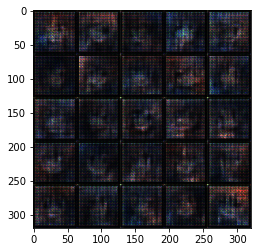

Epoch 1/5 - Batch 210/1039:  Discriminator loss = 2.9360  Generator loss = 0.0969
Epoch 1/5 - Batch 220/1039:  Discriminator loss = 1.8549  Generator loss = 1.5739
Epoch 1/5 - Batch 230/1039:  Discriminator loss = 1.7700  Generator loss = 1.3288
Epoch 1/5 - Batch 240/1039:  Discriminator loss = 1.7970  Generator loss = 1.9949
Epoch 1/5 - Batch 250/1039:  Discriminator loss = 1.8029  Generator loss = 0.5350
Epoch 1/5 - Batch 260/1039:  Discriminator loss = 1.9665  Generator loss = 0.2926
Epoch 1/5 - Batch 270/1039:  Discriminator loss = 2.9400  Generator loss = 0.1037
Epoch 1/5 - Batch 280/1039:  Discriminator loss = 2.3790  Generator loss = 1.7515
Epoch 1/5 - Batch 290/1039:  Discriminator loss = 3.4576  Generator loss = 3.3736
Epoch 1/5 - Batch 300/1039:  Discriminator loss = 1.8298  Generator loss = 0.3316


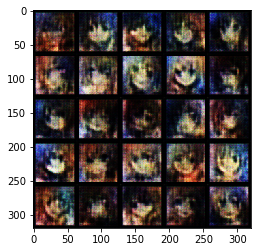

Epoch 1/5 - Batch 310/1039:  Discriminator loss = 2.3851  Generator loss = 0.1725
Epoch 1/5 - Batch 320/1039:  Discriminator loss = 1.8968  Generator loss = 0.2938
Epoch 1/5 - Batch 330/1039:  Discriminator loss = 1.9613  Generator loss = 0.2851
Epoch 1/5 - Batch 340/1039:  Discriminator loss = 1.8954  Generator loss = 0.2924
Epoch 1/5 - Batch 350/1039:  Discriminator loss = 1.8218  Generator loss = 0.3041
Epoch 1/5 - Batch 360/1039:  Discriminator loss = 1.6342  Generator loss = 0.4277
Epoch 1/5 - Batch 370/1039:  Discriminator loss = 1.8508  Generator loss = 0.3598
Epoch 1/5 - Batch 380/1039:  Discriminator loss = 1.9069  Generator loss = 0.2707
Epoch 1/5 - Batch 390/1039:  Discriminator loss = 1.6523  Generator loss = 0.8665
Epoch 1/5 - Batch 400/1039:  Discriminator loss = 1.6044  Generator loss = 0.3888


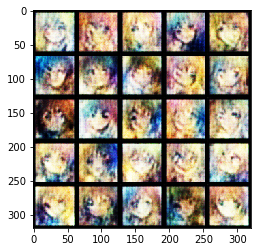

Epoch 1/5 - Batch 410/1039:  Discriminator loss = 2.0642  Generator loss = 0.2593
Epoch 1/5 - Batch 420/1039:  Discriminator loss = 2.1283  Generator loss = 2.0343
Epoch 1/5 - Batch 430/1039:  Discriminator loss = 1.8830  Generator loss = 2.0454
Epoch 1/5 - Batch 440/1039:  Discriminator loss = 1.7010  Generator loss = 1.0410
Epoch 1/5 - Batch 450/1039:  Discriminator loss = 1.4964  Generator loss = 1.1319
Epoch 1/5 - Batch 460/1039:  Discriminator loss = 1.9226  Generator loss = 1.8461
Epoch 1/5 - Batch 470/1039:  Discriminator loss = 1.5097  Generator loss = 1.1033
Epoch 1/5 - Batch 480/1039:  Discriminator loss = 1.5337  Generator loss = 0.5988
Epoch 1/5 - Batch 490/1039:  Discriminator loss = 1.7389  Generator loss = 0.3813
Epoch 1/5 - Batch 500/1039:  Discriminator loss = 2.1265  Generator loss = 0.2122


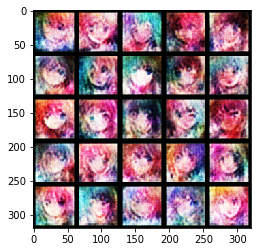

Epoch 1/5 - Batch 510/1039:  Discriminator loss = 1.5578  Generator loss = 0.5229
Epoch 1/5 - Batch 520/1039:  Discriminator loss = 1.6560  Generator loss = 0.3356
Epoch 1/5 - Batch 530/1039:  Discriminator loss = 1.5630  Generator loss = 0.4191
Epoch 1/5 - Batch 540/1039:  Discriminator loss = 1.2340  Generator loss = 1.6124
Epoch 1/5 - Batch 550/1039:  Discriminator loss = 1.3598  Generator loss = 1.3484
Epoch 1/5 - Batch 560/1039:  Discriminator loss = 1.2379  Generator loss = 1.3435
Epoch 1/5 - Batch 570/1039:  Discriminator loss = 1.5738  Generator loss = 1.2486
Epoch 1/5 - Batch 580/1039:  Discriminator loss = 2.0346  Generator loss = 0.2212
Epoch 1/5 - Batch 590/1039:  Discriminator loss = 1.6537  Generator loss = 0.4683
Epoch 1/5 - Batch 600/1039:  Discriminator loss = 2.9282  Generator loss = 2.4742


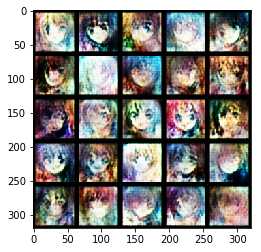

Epoch 1/5 - Batch 610/1039:  Discriminator loss = 1.4782  Generator loss = 1.0833
Epoch 1/5 - Batch 620/1039:  Discriminator loss = 1.6635  Generator loss = 1.2690
Epoch 1/5 - Batch 630/1039:  Discriminator loss = 1.7455  Generator loss = 0.7413
Epoch 1/5 - Batch 640/1039:  Discriminator loss = 2.1901  Generator loss = 0.2646
Epoch 1/5 - Batch 650/1039:  Discriminator loss = 2.3319  Generator loss = 1.8152
Epoch 1/5 - Batch 660/1039:  Discriminator loss = 2.2390  Generator loss = 1.7901
Epoch 1/5 - Batch 670/1039:  Discriminator loss = 1.5794  Generator loss = 0.4938
Epoch 1/5 - Batch 680/1039:  Discriminator loss = 1.6154  Generator loss = 0.6180
Epoch 1/5 - Batch 690/1039:  Discriminator loss = 1.4147  Generator loss = 0.6123
Epoch 1/5 - Batch 700/1039:  Discriminator loss = 1.6535  Generator loss = 0.8443


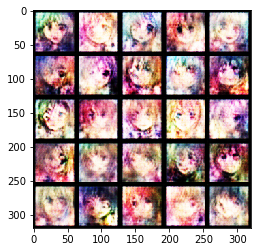

Epoch 1/5 - Batch 710/1039:  Discriminator loss = 1.8522  Generator loss = 0.9645
Epoch 1/5 - Batch 720/1039:  Discriminator loss = 1.9552  Generator loss = 1.9021
Epoch 1/5 - Batch 730/1039:  Discriminator loss = 1.9733  Generator loss = 0.2689
Epoch 1/5 - Batch 740/1039:  Discriminator loss = 1.6114  Generator loss = 0.5653
Epoch 1/5 - Batch 750/1039:  Discriminator loss = 2.0589  Generator loss = 1.6500
Epoch 1/5 - Batch 760/1039:  Discriminator loss = 1.4564  Generator loss = 0.6269
Epoch 1/5 - Batch 770/1039:  Discriminator loss = 2.1728  Generator loss = 0.2211
Epoch 1/5 - Batch 780/1039:  Discriminator loss = 1.5787  Generator loss = 0.4558
Epoch 1/5 - Batch 790/1039:  Discriminator loss = 1.7267  Generator loss = 0.4549
Epoch 1/5 - Batch 800/1039:  Discriminator loss = 1.7282  Generator loss = 0.3798


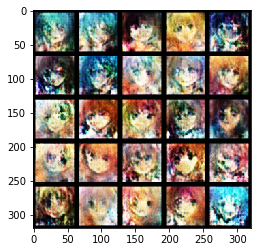

Epoch 1/5 - Batch 810/1039:  Discriminator loss = 1.9350  Generator loss = 0.2904
Epoch 1/5 - Batch 820/1039:  Discriminator loss = 1.6119  Generator loss = 1.1356
Epoch 1/5 - Batch 830/1039:  Discriminator loss = 1.9451  Generator loss = 1.1060
Epoch 1/5 - Batch 840/1039:  Discriminator loss = 1.6514  Generator loss = 0.5104
Epoch 1/5 - Batch 850/1039:  Discriminator loss = 1.4263  Generator loss = 0.7124
Epoch 1/5 - Batch 860/1039:  Discriminator loss = 2.0389  Generator loss = 1.2950
Epoch 1/5 - Batch 870/1039:  Discriminator loss = 1.8259  Generator loss = 1.3865
Epoch 1/5 - Batch 880/1039:  Discriminator loss = 1.6018  Generator loss = 0.8277
Epoch 1/5 - Batch 890/1039:  Discriminator loss = 1.5176  Generator loss = 0.6686
Epoch 1/5 - Batch 900/1039:  Discriminator loss = 2.6274  Generator loss = 2.5431


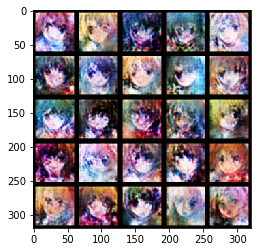

Epoch 1/5 - Batch 910/1039:  Discriminator loss = 2.1296  Generator loss = 0.2303
Epoch 1/5 - Batch 920/1039:  Discriminator loss = 2.5282  Generator loss = 2.0827
Epoch 1/5 - Batch 930/1039:  Discriminator loss = 1.9524  Generator loss = 1.6469
Epoch 1/5 - Batch 940/1039:  Discriminator loss = 1.7862  Generator loss = 0.4533
Epoch 1/5 - Batch 950/1039:  Discriminator loss = 1.7362  Generator loss = 0.8307
Epoch 1/5 - Batch 960/1039:  Discriminator loss = 1.7383  Generator loss = 0.3642
Epoch 1/5 - Batch 970/1039:  Discriminator loss = 1.6251  Generator loss = 0.5851
Epoch 1/5 - Batch 980/1039:  Discriminator loss = 1.5854  Generator loss = 0.7864
Epoch 1/5 - Batch 990/1039:  Discriminator loss = 1.6253  Generator loss = 1.2711
Epoch 1/5 - Batch 1000/1039:  Discriminator loss = 1.8939  Generator loss = 1.4899


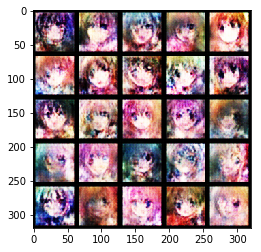

Epoch 1/5 - Batch 1010/1039:  Discriminator loss = 1.4145  Generator loss = 0.9979
Epoch 1/5 - Batch 1020/1039:  Discriminator loss = 1.4371  Generator loss = 0.8394
Epoch 1/5 - Batch 1030/1039:  Discriminator loss = 2.0464  Generator loss = 1.6834
Epoch 2/5 - Batch 10/1039:  Discriminator loss = 1.6459  Generator loss = 0.9558
Epoch 2/5 - Batch 20/1039:  Discriminator loss = 1.8209  Generator loss = 0.3003
Epoch 2/5 - Batch 30/1039:  Discriminator loss = 1.6613  Generator loss = 0.4664
Epoch 2/5 - Batch 40/1039:  Discriminator loss = 1.8432  Generator loss = 2.1716
Epoch 2/5 - Batch 50/1039:  Discriminator loss = 1.7828  Generator loss = 0.3380
Epoch 2/5 - Batch 60/1039:  Discriminator loss = 1.9843  Generator loss = 0.2741
Epoch 2/5 - Batch 70/1039:  Discriminator loss = 1.9152  Generator loss = 1.0926
Epoch 2/5 - Batch 80/1039:  Discriminator loss = 1.5269  Generator loss = 0.5968
Epoch 2/5 - Batch 90/1039:  Discriminator loss = 1.6799  Generator loss = 1.1482
Epoch 2/5 - Batch 100/

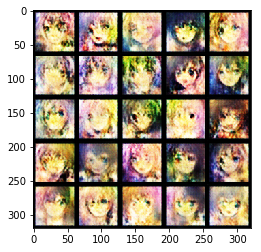

Epoch 2/5 - Batch 110/1039:  Discriminator loss = 2.1562  Generator loss = 1.5053
Epoch 2/5 - Batch 120/1039:  Discriminator loss = 1.7497  Generator loss = 0.4130
Epoch 2/5 - Batch 130/1039:  Discriminator loss = 1.6683  Generator loss = 0.5446
Epoch 2/5 - Batch 140/1039:  Discriminator loss = 1.7636  Generator loss = 0.3816
Epoch 2/5 - Batch 150/1039:  Discriminator loss = 1.8285  Generator loss = 0.3571
Epoch 2/5 - Batch 160/1039:  Discriminator loss = 1.5729  Generator loss = 0.6244
Epoch 2/5 - Batch 170/1039:  Discriminator loss = 1.7394  Generator loss = 0.3425
Epoch 2/5 - Batch 180/1039:  Discriminator loss = 1.3568  Generator loss = 0.7217
Epoch 2/5 - Batch 190/1039:  Discriminator loss = 1.5719  Generator loss = 0.5093
Epoch 2/5 - Batch 200/1039:  Discriminator loss = 1.8057  Generator loss = 0.2988


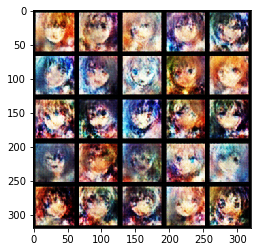

Epoch 2/5 - Batch 210/1039:  Discriminator loss = 1.7742  Generator loss = 0.3492
Epoch 2/5 - Batch 220/1039:  Discriminator loss = 1.6562  Generator loss = 0.5034
Epoch 2/5 - Batch 230/1039:  Discriminator loss = 1.7447  Generator loss = 1.0469
Epoch 2/5 - Batch 240/1039:  Discriminator loss = 1.5759  Generator loss = 0.8693
Epoch 2/5 - Batch 250/1039:  Discriminator loss = 1.9874  Generator loss = 1.7885
Epoch 2/5 - Batch 260/1039:  Discriminator loss = 1.3405  Generator loss = 0.9136
Epoch 2/5 - Batch 270/1039:  Discriminator loss = 1.8542  Generator loss = 0.7036
Epoch 2/5 - Batch 280/1039:  Discriminator loss = 1.5564  Generator loss = 0.8501
Epoch 2/5 - Batch 290/1039:  Discriminator loss = 2.1227  Generator loss = 1.6882
Epoch 2/5 - Batch 300/1039:  Discriminator loss = 1.7215  Generator loss = 0.3392


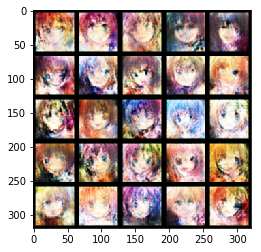

Epoch 2/5 - Batch 310/1039:  Discriminator loss = 1.3952  Generator loss = 1.5629
Epoch 2/5 - Batch 320/1039:  Discriminator loss = 1.7661  Generator loss = 0.3599
Epoch 2/5 - Batch 330/1039:  Discriminator loss = 1.5814  Generator loss = 0.4817
Epoch 2/5 - Batch 340/1039:  Discriminator loss = 1.4749  Generator loss = 0.4795
Epoch 2/5 - Batch 350/1039:  Discriminator loss = 1.4570  Generator loss = 1.0384
Epoch 2/5 - Batch 360/1039:  Discriminator loss = 1.7008  Generator loss = 0.3548
Epoch 2/5 - Batch 370/1039:  Discriminator loss = 1.7498  Generator loss = 0.3421
Epoch 2/5 - Batch 380/1039:  Discriminator loss = 1.4733  Generator loss = 1.1731
Epoch 2/5 - Batch 390/1039:  Discriminator loss = 1.7739  Generator loss = 1.2742
Epoch 2/5 - Batch 400/1039:  Discriminator loss = 1.7163  Generator loss = 0.3719


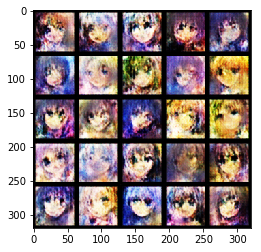

Epoch 2/5 - Batch 410/1039:  Discriminator loss = 1.4743  Generator loss = 0.7185
Epoch 2/5 - Batch 420/1039:  Discriminator loss = 1.7603  Generator loss = 1.1923
Epoch 2/5 - Batch 430/1039:  Discriminator loss = 1.5155  Generator loss = 0.4847
Epoch 2/5 - Batch 440/1039:  Discriminator loss = 1.6133  Generator loss = 0.5211
Epoch 2/5 - Batch 450/1039:  Discriminator loss = 2.9418  Generator loss = 0.0931
Epoch 2/5 - Batch 460/1039:  Discriminator loss = 1.8767  Generator loss = 0.2916
Epoch 2/5 - Batch 470/1039:  Discriminator loss = 2.2698  Generator loss = 1.9193
Epoch 2/5 - Batch 480/1039:  Discriminator loss = 1.8525  Generator loss = 0.2818
Epoch 2/5 - Batch 490/1039:  Discriminator loss = 1.5915  Generator loss = 1.2030
Epoch 2/5 - Batch 500/1039:  Discriminator loss = 1.3805  Generator loss = 1.2420


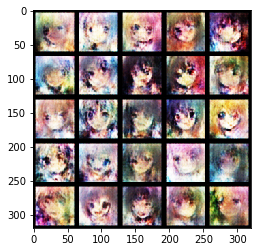

Epoch 2/5 - Batch 510/1039:  Discriminator loss = 1.7460  Generator loss = 0.3252
Epoch 2/5 - Batch 520/1039:  Discriminator loss = 1.8261  Generator loss = 0.3060
Epoch 2/5 - Batch 530/1039:  Discriminator loss = 1.5694  Generator loss = 0.4358
Epoch 2/5 - Batch 540/1039:  Discriminator loss = 1.4397  Generator loss = 0.9264
Epoch 2/5 - Batch 550/1039:  Discriminator loss = 1.4591  Generator loss = 0.7137
Epoch 2/5 - Batch 560/1039:  Discriminator loss = 1.4463  Generator loss = 0.8761
Epoch 2/5 - Batch 570/1039:  Discriminator loss = 1.6141  Generator loss = 0.6193
Epoch 2/5 - Batch 580/1039:  Discriminator loss = 1.6549  Generator loss = 0.6316
Epoch 2/5 - Batch 590/1039:  Discriminator loss = 1.7218  Generator loss = 0.7505
Epoch 2/5 - Batch 600/1039:  Discriminator loss = 1.4667  Generator loss = 1.0756


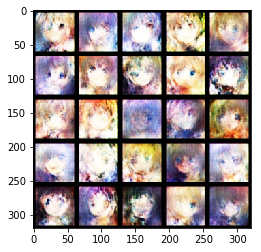

Epoch 2/5 - Batch 610/1039:  Discriminator loss = 1.4542  Generator loss = 1.2057
Epoch 2/5 - Batch 620/1039:  Discriminator loss = 1.8312  Generator loss = 0.3688
Epoch 2/5 - Batch 630/1039:  Discriminator loss = 2.2395  Generator loss = 2.2586
Epoch 2/5 - Batch 640/1039:  Discriminator loss = 1.6878  Generator loss = 0.4223
Epoch 2/5 - Batch 650/1039:  Discriminator loss = 1.3797  Generator loss = 1.2979
Epoch 2/5 - Batch 660/1039:  Discriminator loss = 1.5868  Generator loss = 0.9290
Epoch 2/5 - Batch 670/1039:  Discriminator loss = 1.6777  Generator loss = 1.7864
Epoch 2/5 - Batch 680/1039:  Discriminator loss = 1.8116  Generator loss = 0.3170
Epoch 2/5 - Batch 690/1039:  Discriminator loss = 1.6018  Generator loss = 0.6383
Epoch 2/5 - Batch 700/1039:  Discriminator loss = 1.4370  Generator loss = 0.6361


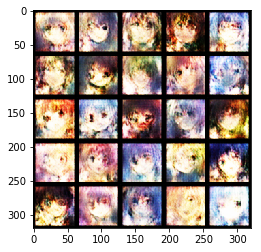

Epoch 2/5 - Batch 710/1039:  Discriminator loss = 1.8362  Generator loss = 0.3318
Epoch 2/5 - Batch 720/1039:  Discriminator loss = 1.4200  Generator loss = 1.2524
Epoch 2/5 - Batch 730/1039:  Discriminator loss = 1.3513  Generator loss = 0.6604
Epoch 2/5 - Batch 740/1039:  Discriminator loss = 1.4800  Generator loss = 0.4802
Epoch 2/5 - Batch 750/1039:  Discriminator loss = 1.5490  Generator loss = 0.4511
Epoch 2/5 - Batch 760/1039:  Discriminator loss = 1.7571  Generator loss = 0.3468
Epoch 2/5 - Batch 770/1039:  Discriminator loss = 1.6010  Generator loss = 0.3641
Epoch 2/5 - Batch 780/1039:  Discriminator loss = 1.7552  Generator loss = 0.3166
Epoch 2/5 - Batch 790/1039:  Discriminator loss = 1.6141  Generator loss = 1.7136
Epoch 2/5 - Batch 800/1039:  Discriminator loss = 1.8303  Generator loss = 1.6125


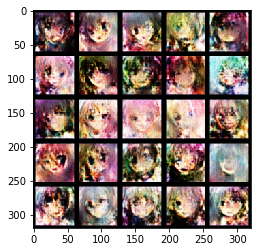

Epoch 2/5 - Batch 810/1039:  Discriminator loss = 1.5312  Generator loss = 0.4377
Epoch 2/5 - Batch 820/1039:  Discriminator loss = 1.3970  Generator loss = 0.6078
Epoch 2/5 - Batch 830/1039:  Discriminator loss = 1.6086  Generator loss = 1.3062
Epoch 2/5 - Batch 840/1039:  Discriminator loss = 1.4142  Generator loss = 0.5127
Epoch 2/5 - Batch 850/1039:  Discriminator loss = 1.3156  Generator loss = 0.6196
Epoch 2/5 - Batch 860/1039:  Discriminator loss = 1.4590  Generator loss = 0.5184
Epoch 2/5 - Batch 870/1039:  Discriminator loss = 1.6845  Generator loss = 0.3467
Epoch 2/5 - Batch 880/1039:  Discriminator loss = 1.7687  Generator loss = 0.3214
Epoch 2/5 - Batch 890/1039:  Discriminator loss = 1.9141  Generator loss = 0.2905
Epoch 2/5 - Batch 900/1039:  Discriminator loss = 1.4132  Generator loss = 1.4459


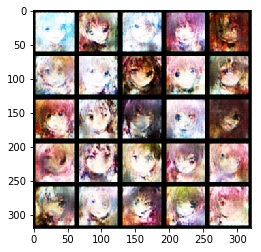

Epoch 2/5 - Batch 910/1039:  Discriminator loss = 1.7057  Generator loss = 1.2629
Epoch 2/5 - Batch 920/1039:  Discriminator loss = 2.3046  Generator loss = 2.7369
Epoch 2/5 - Batch 930/1039:  Discriminator loss = 1.4466  Generator loss = 0.7934
Epoch 2/5 - Batch 940/1039:  Discriminator loss = 1.5264  Generator loss = 1.7600
Epoch 2/5 - Batch 950/1039:  Discriminator loss = 1.4816  Generator loss = 0.8359
Epoch 2/5 - Batch 960/1039:  Discriminator loss = 1.6027  Generator loss = 0.3605
Epoch 2/5 - Batch 970/1039:  Discriminator loss = 1.8336  Generator loss = 1.9738
Epoch 2/5 - Batch 980/1039:  Discriminator loss = 1.5491  Generator loss = 0.5206
Epoch 2/5 - Batch 990/1039:  Discriminator loss = 1.3265  Generator loss = 0.8078
Epoch 2/5 - Batch 1000/1039:  Discriminator loss = 1.3812  Generator loss = 1.1397


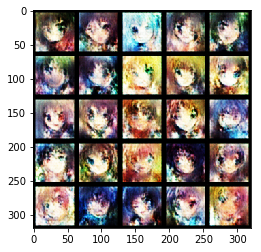

Epoch 2/5 - Batch 1010/1039:  Discriminator loss = 1.7094  Generator loss = 0.3592
Epoch 2/5 - Batch 1020/1039:  Discriminator loss = 1.4068  Generator loss = 0.5624
Epoch 2/5 - Batch 1030/1039:  Discriminator loss = 1.5810  Generator loss = 1.5879
Epoch 3/5 - Batch 10/1039:  Discriminator loss = 1.5644  Generator loss = 0.6817
Epoch 3/5 - Batch 20/1039:  Discriminator loss = 1.5152  Generator loss = 1.1915
Epoch 3/5 - Batch 30/1039:  Discriminator loss = 1.5367  Generator loss = 0.8512
Epoch 3/5 - Batch 40/1039:  Discriminator loss = 1.5089  Generator loss = 0.8033
Epoch 3/5 - Batch 50/1039:  Discriminator loss = 1.3979  Generator loss = 1.0446
Epoch 3/5 - Batch 60/1039:  Discriminator loss = 1.4243  Generator loss = 0.7597
Epoch 3/5 - Batch 70/1039:  Discriminator loss = 1.5328  Generator loss = 1.4681
Epoch 3/5 - Batch 80/1039:  Discriminator loss = 1.6148  Generator loss = 0.4588
Epoch 3/5 - Batch 90/1039:  Discriminator loss = 1.5023  Generator loss = 0.4424
Epoch 3/5 - Batch 100/

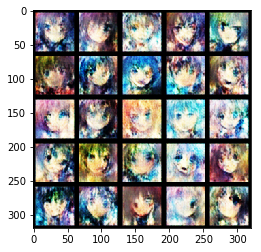

Epoch 3/5 - Batch 110/1039:  Discriminator loss = 1.7360  Generator loss = 0.3275
Epoch 3/5 - Batch 120/1039:  Discriminator loss = 1.4991  Generator loss = 0.4518
Epoch 3/5 - Batch 130/1039:  Discriminator loss = 1.8187  Generator loss = 0.2815
Epoch 3/5 - Batch 140/1039:  Discriminator loss = 1.3847  Generator loss = 0.6344
Epoch 3/5 - Batch 150/1039:  Discriminator loss = 1.4833  Generator loss = 1.4844
Epoch 3/5 - Batch 160/1039:  Discriminator loss = 1.4195  Generator loss = 0.7856
Epoch 3/5 - Batch 170/1039:  Discriminator loss = 1.3908  Generator loss = 0.6114
Epoch 3/5 - Batch 180/1039:  Discriminator loss = 1.4657  Generator loss = 1.0526
Epoch 3/5 - Batch 190/1039:  Discriminator loss = 1.5968  Generator loss = 0.4607
Epoch 3/5 - Batch 200/1039:  Discriminator loss = 1.8183  Generator loss = 0.3211


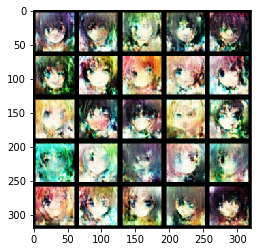

Epoch 3/5 - Batch 210/1039:  Discriminator loss = 1.4867  Generator loss = 0.4465
Epoch 3/5 - Batch 220/1039:  Discriminator loss = 1.8139  Generator loss = 1.9817
Epoch 3/5 - Batch 230/1039:  Discriminator loss = 1.7775  Generator loss = 0.3129
Epoch 3/5 - Batch 240/1039:  Discriminator loss = 1.2910  Generator loss = 1.0643
Epoch 3/5 - Batch 250/1039:  Discriminator loss = 1.3686  Generator loss = 0.8551
Epoch 3/5 - Batch 260/1039:  Discriminator loss = 1.5540  Generator loss = 1.7556
Epoch 3/5 - Batch 270/1039:  Discriminator loss = 1.6216  Generator loss = 0.4941
Epoch 3/5 - Batch 280/1039:  Discriminator loss = 1.4532  Generator loss = 0.5465
Epoch 3/5 - Batch 290/1039:  Discriminator loss = 2.0710  Generator loss = 0.2326
Epoch 3/5 - Batch 300/1039:  Discriminator loss = 1.2101  Generator loss = 1.1368


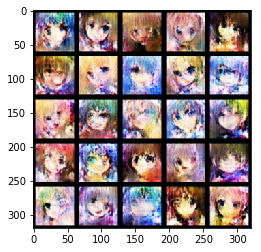

Epoch 3/5 - Batch 310/1039:  Discriminator loss = 1.4004  Generator loss = 1.0602
Epoch 3/5 - Batch 320/1039:  Discriminator loss = 1.6292  Generator loss = 1.4558
Epoch 3/5 - Batch 330/1039:  Discriminator loss = 1.2896  Generator loss = 1.2595
Epoch 3/5 - Batch 340/1039:  Discriminator loss = 1.5144  Generator loss = 0.4191
Epoch 3/5 - Batch 350/1039:  Discriminator loss = 1.5510  Generator loss = 0.4315
Epoch 3/5 - Batch 360/1039:  Discriminator loss = 1.3525  Generator loss = 1.2126
Epoch 3/5 - Batch 370/1039:  Discriminator loss = 1.3685  Generator loss = 1.4990
Epoch 3/5 - Batch 380/1039:  Discriminator loss = 1.2847  Generator loss = 0.7108
Epoch 3/5 - Batch 390/1039:  Discriminator loss = 1.3773  Generator loss = 0.5947
Epoch 3/5 - Batch 400/1039:  Discriminator loss = 1.6477  Generator loss = 0.3983


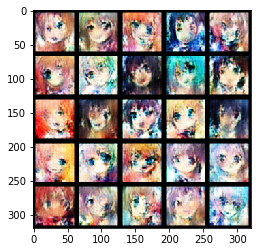

Epoch 3/5 - Batch 410/1039:  Discriminator loss = 1.7033  Generator loss = 1.7332
Epoch 3/5 - Batch 420/1039:  Discriminator loss = 1.4058  Generator loss = 0.6446
Epoch 3/5 - Batch 430/1039:  Discriminator loss = 1.3573  Generator loss = 0.6648
Epoch 3/5 - Batch 440/1039:  Discriminator loss = 1.9948  Generator loss = 1.6247
Epoch 3/5 - Batch 450/1039:  Discriminator loss = 1.7435  Generator loss = 0.3173
Epoch 3/5 - Batch 460/1039:  Discriminator loss = 2.1774  Generator loss = 2.3639
Epoch 3/5 - Batch 470/1039:  Discriminator loss = 1.4478  Generator loss = 0.5337
Epoch 3/5 - Batch 480/1039:  Discriminator loss = 1.6374  Generator loss = 1.9797
Epoch 3/5 - Batch 490/1039:  Discriminator loss = 1.3906  Generator loss = 0.7602
Epoch 3/5 - Batch 500/1039:  Discriminator loss = 1.5658  Generator loss = 0.4785


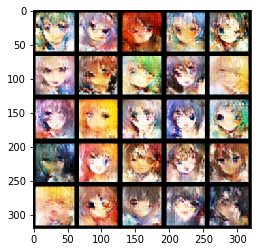

Epoch 3/5 - Batch 510/1039:  Discriminator loss = 1.2739  Generator loss = 0.8450
Epoch 3/5 - Batch 520/1039:  Discriminator loss = 2.3433  Generator loss = 2.6960
Epoch 3/5 - Batch 530/1039:  Discriminator loss = 1.7543  Generator loss = 0.3056
Epoch 3/5 - Batch 540/1039:  Discriminator loss = 1.9098  Generator loss = 0.2698
Epoch 3/5 - Batch 550/1039:  Discriminator loss = 1.3019  Generator loss = 0.6289
Epoch 3/5 - Batch 560/1039:  Discriminator loss = 1.5294  Generator loss = 0.7326
Epoch 3/5 - Batch 570/1039:  Discriminator loss = 1.5702  Generator loss = 0.9000
Epoch 3/5 - Batch 580/1039:  Discriminator loss = 1.5268  Generator loss = 1.6078
Epoch 3/5 - Batch 590/1039:  Discriminator loss = 1.4746  Generator loss = 0.4735
Epoch 3/5 - Batch 600/1039:  Discriminator loss = 1.4568  Generator loss = 1.4936


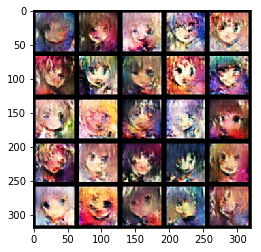

Epoch 3/5 - Batch 610/1039:  Discriminator loss = 1.3064  Generator loss = 0.5830
Epoch 3/5 - Batch 620/1039:  Discriminator loss = 1.4691  Generator loss = 0.9646
Epoch 3/5 - Batch 630/1039:  Discriminator loss = 1.4513  Generator loss = 0.5611
Epoch 3/5 - Batch 640/1039:  Discriminator loss = 1.4733  Generator loss = 0.8218
Epoch 3/5 - Batch 650/1039:  Discriminator loss = 1.2583  Generator loss = 0.8358
Epoch 3/5 - Batch 660/1039:  Discriminator loss = 1.4617  Generator loss = 0.4902
Epoch 3/5 - Batch 670/1039:  Discriminator loss = 1.6037  Generator loss = 1.6617
Epoch 3/5 - Batch 680/1039:  Discriminator loss = 1.5723  Generator loss = 0.5966
Epoch 3/5 - Batch 690/1039:  Discriminator loss = 1.3259  Generator loss = 0.6492
Epoch 3/5 - Batch 700/1039:  Discriminator loss = 1.4390  Generator loss = 1.0550


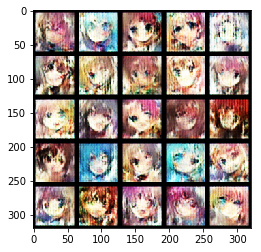

Epoch 3/5 - Batch 710/1039:  Discriminator loss = 1.5423  Generator loss = 0.4342
Epoch 3/5 - Batch 720/1039:  Discriminator loss = 1.3392  Generator loss = 0.5609
Epoch 3/5 - Batch 730/1039:  Discriminator loss = 1.8751  Generator loss = 0.2521
Epoch 3/5 - Batch 740/1039:  Discriminator loss = 1.3182  Generator loss = 1.1598
Epoch 3/5 - Batch 750/1039:  Discriminator loss = 1.4293  Generator loss = 1.0028
Epoch 3/5 - Batch 760/1039:  Discriminator loss = 1.4360  Generator loss = 1.1447
Epoch 3/5 - Batch 770/1039:  Discriminator loss = 1.6490  Generator loss = 0.3503
Epoch 3/5 - Batch 780/1039:  Discriminator loss = 1.6103  Generator loss = 0.3797
Epoch 3/5 - Batch 790/1039:  Discriminator loss = 1.6749  Generator loss = 2.1251
Epoch 3/5 - Batch 800/1039:  Discriminator loss = 1.3327  Generator loss = 1.0339


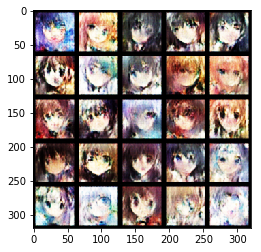

Epoch 3/5 - Batch 810/1039:  Discriminator loss = 1.0891  Generator loss = 1.5982
Epoch 3/5 - Batch 820/1039:  Discriminator loss = 1.6722  Generator loss = 0.3669
Epoch 3/5 - Batch 830/1039:  Discriminator loss = 1.3170  Generator loss = 1.7745
Epoch 3/5 - Batch 840/1039:  Discriminator loss = 1.5666  Generator loss = 0.3949
Epoch 3/5 - Batch 850/1039:  Discriminator loss = 1.3129  Generator loss = 1.3359
Epoch 3/5 - Batch 860/1039:  Discriminator loss = 1.3751  Generator loss = 0.5982
Epoch 3/5 - Batch 870/1039:  Discriminator loss = 1.7951  Generator loss = 2.3281
Epoch 3/5 - Batch 880/1039:  Discriminator loss = 1.7961  Generator loss = 1.8210
Epoch 3/5 - Batch 890/1039:  Discriminator loss = 1.2070  Generator loss = 0.6671
Epoch 3/5 - Batch 900/1039:  Discriminator loss = 1.9358  Generator loss = 2.1805


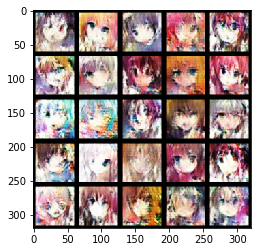

Epoch 3/5 - Batch 910/1039:  Discriminator loss = 1.6546  Generator loss = 1.2008
Epoch 3/5 - Batch 920/1039:  Discriminator loss = 1.6009  Generator loss = 1.6573
Epoch 3/5 - Batch 930/1039:  Discriminator loss = 1.4474  Generator loss = 1.6311
Epoch 3/5 - Batch 940/1039:  Discriminator loss = 1.4076  Generator loss = 1.3528
Epoch 3/5 - Batch 950/1039:  Discriminator loss = 1.5992  Generator loss = 0.3678
Epoch 3/5 - Batch 960/1039:  Discriminator loss = 1.4173  Generator loss = 1.0456
Epoch 3/5 - Batch 970/1039:  Discriminator loss = 1.4263  Generator loss = 0.4612
Epoch 3/5 - Batch 980/1039:  Discriminator loss = 1.6431  Generator loss = 1.6044
Epoch 3/5 - Batch 990/1039:  Discriminator loss = 1.1839  Generator loss = 0.8622
Epoch 3/5 - Batch 1000/1039:  Discriminator loss = 1.2183  Generator loss = 0.9784


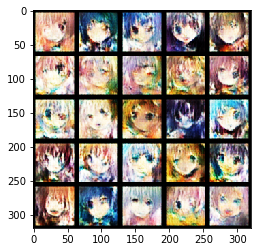

Epoch 3/5 - Batch 1010/1039:  Discriminator loss = 1.4968  Generator loss = 1.6157
Epoch 3/5 - Batch 1020/1039:  Discriminator loss = 1.1701  Generator loss = 0.8464
Epoch 3/5 - Batch 1030/1039:  Discriminator loss = 1.8672  Generator loss = 2.2021
Epoch 4/5 - Batch 10/1039:  Discriminator loss = 1.1630  Generator loss = 1.4271
Epoch 4/5 - Batch 20/1039:  Discriminator loss = 1.6477  Generator loss = 1.7891
Epoch 4/5 - Batch 30/1039:  Discriminator loss = 2.2358  Generator loss = 0.1866
Epoch 4/5 - Batch 40/1039:  Discriminator loss = 1.0959  Generator loss = 1.0080
Epoch 4/5 - Batch 50/1039:  Discriminator loss = 1.1542  Generator loss = 0.7048
Epoch 4/5 - Batch 60/1039:  Discriminator loss = 1.1923  Generator loss = 1.1491
Epoch 4/5 - Batch 70/1039:  Discriminator loss = 1.5888  Generator loss = 0.4297
Epoch 4/5 - Batch 80/1039:  Discriminator loss = 1.3621  Generator loss = 0.5458
Epoch 4/5 - Batch 90/1039:  Discriminator loss = 1.0342  Generator loss = 1.1167
Epoch 4/5 - Batch 100/

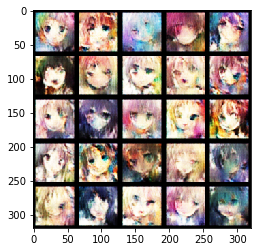

Epoch 4/5 - Batch 110/1039:  Discriminator loss = 1.2661  Generator loss = 0.5635
Epoch 4/5 - Batch 120/1039:  Discriminator loss = 1.8268  Generator loss = 0.3481
Epoch 4/5 - Batch 130/1039:  Discriminator loss = 1.0465  Generator loss = 1.5163
Epoch 4/5 - Batch 140/1039:  Discriminator loss = 1.6609  Generator loss = 0.3417
Epoch 4/5 - Batch 150/1039:  Discriminator loss = 1.3552  Generator loss = 0.7229
Epoch 4/5 - Batch 160/1039:  Discriminator loss = 1.6929  Generator loss = 0.3745
Epoch 4/5 - Batch 170/1039:  Discriminator loss = 1.1817  Generator loss = 1.3544
Epoch 4/5 - Batch 180/1039:  Discriminator loss = 1.0179  Generator loss = 1.4217
Epoch 4/5 - Batch 190/1039:  Discriminator loss = 1.1926  Generator loss = 0.8507
Epoch 4/5 - Batch 200/1039:  Discriminator loss = 1.5849  Generator loss = 0.4666


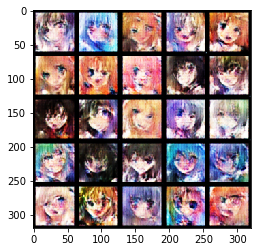

Epoch 4/5 - Batch 210/1039:  Discriminator loss = 1.4864  Generator loss = 0.5060
Epoch 4/5 - Batch 220/1039:  Discriminator loss = 1.1616  Generator loss = 0.7748
Epoch 4/5 - Batch 230/1039:  Discriminator loss = 1.3605  Generator loss = 2.1061
Epoch 4/5 - Batch 240/1039:  Discriminator loss = 1.2525  Generator loss = 1.3133
Epoch 4/5 - Batch 250/1039:  Discriminator loss = 1.5781  Generator loss = 0.3639
Epoch 4/5 - Batch 260/1039:  Discriminator loss = 1.1805  Generator loss = 0.7200
Epoch 4/5 - Batch 270/1039:  Discriminator loss = 4.5699  Generator loss = 5.7311
Epoch 4/5 - Batch 280/1039:  Discriminator loss = 1.8113  Generator loss = 0.3222
Epoch 4/5 - Batch 290/1039:  Discriminator loss = 1.5129  Generator loss = 2.5986
Epoch 4/5 - Batch 300/1039:  Discriminator loss = 1.4664  Generator loss = 0.5017


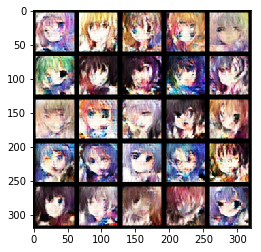

Epoch 4/5 - Batch 310/1039:  Discriminator loss = 0.9899  Generator loss = 1.5908
Epoch 4/5 - Batch 320/1039:  Discriminator loss = 1.6253  Generator loss = 0.3907
Epoch 4/5 - Batch 330/1039:  Discriminator loss = 1.1311  Generator loss = 1.3080
Epoch 4/5 - Batch 340/1039:  Discriminator loss = 1.2755  Generator loss = 1.1418
Epoch 4/5 - Batch 350/1039:  Discriminator loss = 1.7123  Generator loss = 3.0418
Epoch 4/5 - Batch 360/1039:  Discriminator loss = 1.2124  Generator loss = 0.6868
Epoch 4/5 - Batch 370/1039:  Discriminator loss = 1.9452  Generator loss = 0.2619
Epoch 4/5 - Batch 380/1039:  Discriminator loss = 1.6449  Generator loss = 0.3806
Epoch 4/5 - Batch 390/1039:  Discriminator loss = 0.9855  Generator loss = 1.1412
Epoch 4/5 - Batch 400/1039:  Discriminator loss = 1.5283  Generator loss = 0.4478


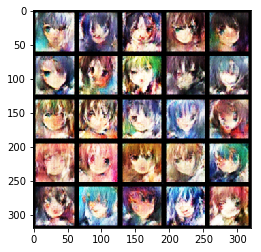

Epoch 4/5 - Batch 410/1039:  Discriminator loss = 2.1978  Generator loss = 0.1966
Epoch 4/5 - Batch 420/1039:  Discriminator loss = 1.4539  Generator loss = 0.4679
Epoch 4/5 - Batch 430/1039:  Discriminator loss = 1.1347  Generator loss = 0.8119
Epoch 4/5 - Batch 440/1039:  Discriminator loss = 1.5454  Generator loss = 0.3984
Epoch 4/5 - Batch 450/1039:  Discriminator loss = 1.7566  Generator loss = 0.3362
Epoch 4/5 - Batch 460/1039:  Discriminator loss = 1.3606  Generator loss = 0.5463
Epoch 4/5 - Batch 470/1039:  Discriminator loss = 1.9043  Generator loss = 0.2714
Epoch 4/5 - Batch 480/1039:  Discriminator loss = 1.8043  Generator loss = 2.3541
Epoch 4/5 - Batch 490/1039:  Discriminator loss = 2.3957  Generator loss = 0.1692
Epoch 4/5 - Batch 500/1039:  Discriminator loss = 1.2421  Generator loss = 0.7446


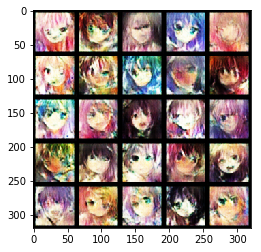

Epoch 4/5 - Batch 510/1039:  Discriminator loss = 0.9839  Generator loss = 1.7004
Epoch 4/5 - Batch 520/1039:  Discriminator loss = 1.1636  Generator loss = 1.6191
Epoch 4/5 - Batch 530/1039:  Discriminator loss = 2.5258  Generator loss = 0.1630
Epoch 4/5 - Batch 540/1039:  Discriminator loss = 1.8434  Generator loss = 2.5036
Epoch 4/5 - Batch 550/1039:  Discriminator loss = 1.3279  Generator loss = 0.7433
Epoch 4/5 - Batch 560/1039:  Discriminator loss = 1.2840  Generator loss = 0.6432
Epoch 4/5 - Batch 570/1039:  Discriminator loss = 1.0246  Generator loss = 0.9324
Epoch 4/5 - Batch 580/1039:  Discriminator loss = 0.9833  Generator loss = 1.5057
Epoch 4/5 - Batch 590/1039:  Discriminator loss = 1.7092  Generator loss = 2.3770
Epoch 4/5 - Batch 600/1039:  Discriminator loss = 1.0247  Generator loss = 1.2103


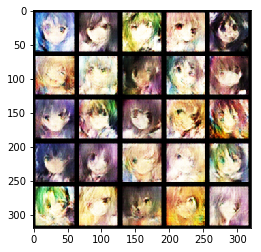

Epoch 4/5 - Batch 610/1039:  Discriminator loss = 1.0603  Generator loss = 0.9377
Epoch 4/5 - Batch 620/1039:  Discriminator loss = 1.1781  Generator loss = 0.7542
Epoch 4/5 - Batch 630/1039:  Discriminator loss = 1.2475  Generator loss = 0.6761
Epoch 4/5 - Batch 640/1039:  Discriminator loss = 2.2571  Generator loss = 3.2669
Epoch 4/5 - Batch 650/1039:  Discriminator loss = 1.0330  Generator loss = 1.3227
Epoch 4/5 - Batch 660/1039:  Discriminator loss = 1.2071  Generator loss = 1.6354
Epoch 4/5 - Batch 670/1039:  Discriminator loss = 1.2033  Generator loss = 1.0058
Epoch 4/5 - Batch 680/1039:  Discriminator loss = 1.2825  Generator loss = 0.7040
Epoch 4/5 - Batch 690/1039:  Discriminator loss = 1.1382  Generator loss = 0.8006
Epoch 4/5 - Batch 700/1039:  Discriminator loss = 1.9131  Generator loss = 0.2829


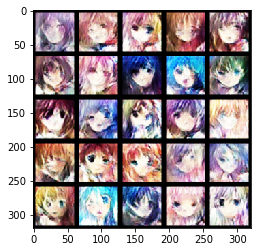

Epoch 4/5 - Batch 710/1039:  Discriminator loss = 1.7795  Generator loss = 2.3974
Epoch 4/5 - Batch 720/1039:  Discriminator loss = 1.0627  Generator loss = 1.9386
Epoch 4/5 - Batch 730/1039:  Discriminator loss = 1.9247  Generator loss = 0.2612
Epoch 4/5 - Batch 740/1039:  Discriminator loss = 1.3130  Generator loss = 0.5800
Epoch 4/5 - Batch 750/1039:  Discriminator loss = 1.6199  Generator loss = 2.6375
Epoch 4/5 - Batch 760/1039:  Discriminator loss = 0.9160  Generator loss = 1.6477
Epoch 4/5 - Batch 770/1039:  Discriminator loss = 0.9742  Generator loss = 1.3875
Epoch 4/5 - Batch 780/1039:  Discriminator loss = 1.1398  Generator loss = 1.9126
Epoch 4/5 - Batch 790/1039:  Discriminator loss = 1.3618  Generator loss = 0.5212
Epoch 4/5 - Batch 800/1039:  Discriminator loss = 1.2774  Generator loss = 0.7346


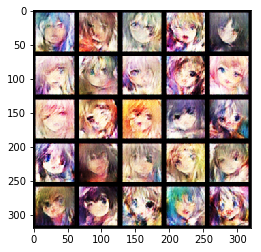

Epoch 4/5 - Batch 810/1039:  Discriminator loss = 0.9039  Generator loss = 1.0292
Epoch 4/5 - Batch 820/1039:  Discriminator loss = 1.3210  Generator loss = 0.6204
Epoch 4/5 - Batch 830/1039:  Discriminator loss = 1.4246  Generator loss = 0.5589
Epoch 4/5 - Batch 840/1039:  Discriminator loss = 1.9663  Generator loss = 0.2768
Epoch 4/5 - Batch 850/1039:  Discriminator loss = 1.2831  Generator loss = 0.6420
Epoch 4/5 - Batch 860/1039:  Discriminator loss = 1.0655  Generator loss = 1.4674
Epoch 4/5 - Batch 870/1039:  Discriminator loss = 2.4596  Generator loss = 3.1321
Epoch 4/5 - Batch 880/1039:  Discriminator loss = 1.2565  Generator loss = 1.0060
Epoch 4/5 - Batch 890/1039:  Discriminator loss = 1.6900  Generator loss = 3.0541
Epoch 4/5 - Batch 900/1039:  Discriminator loss = 1.1361  Generator loss = 1.1342


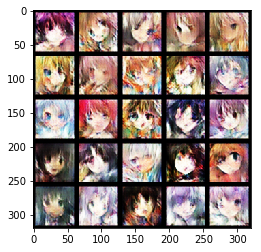

Epoch 4/5 - Batch 910/1039:  Discriminator loss = 1.3060  Generator loss = 0.7931
Epoch 4/5 - Batch 920/1039:  Discriminator loss = 1.5349  Generator loss = 0.4460
Epoch 4/5 - Batch 930/1039:  Discriminator loss = 1.1084  Generator loss = 0.8860
Epoch 4/5 - Batch 940/1039:  Discriminator loss = 1.1038  Generator loss = 1.9627
Epoch 4/5 - Batch 950/1039:  Discriminator loss = 1.0578  Generator loss = 1.0609
Epoch 4/5 - Batch 960/1039:  Discriminator loss = 1.2006  Generator loss = 0.9534
Epoch 4/5 - Batch 970/1039:  Discriminator loss = 1.3222  Generator loss = 0.5343
Epoch 4/5 - Batch 980/1039:  Discriminator loss = 1.2442  Generator loss = 0.6625
Epoch 4/5 - Batch 990/1039:  Discriminator loss = 1.1160  Generator loss = 0.8078
Epoch 4/5 - Batch 1000/1039:  Discriminator loss = 1.0827  Generator loss = 0.8269


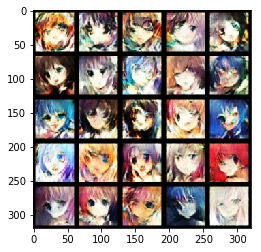

Epoch 4/5 - Batch 1010/1039:  Discriminator loss = 0.9405  Generator loss = 1.6229
Epoch 4/5 - Batch 1020/1039:  Discriminator loss = 1.3189  Generator loss = 0.5484
Epoch 4/5 - Batch 1030/1039:  Discriminator loss = 1.7969  Generator loss = 0.3631
Epoch 5/5 - Batch 10/1039:  Discriminator loss = 0.9294  Generator loss = 1.0618
Epoch 5/5 - Batch 20/1039:  Discriminator loss = 1.2926  Generator loss = 1.5810
Epoch 5/5 - Batch 30/1039:  Discriminator loss = 1.9933  Generator loss = 0.2733
Epoch 5/5 - Batch 40/1039:  Discriminator loss = 1.5525  Generator loss = 2.3111
Epoch 5/5 - Batch 50/1039:  Discriminator loss = 1.6666  Generator loss = 0.3343
Epoch 5/5 - Batch 60/1039:  Discriminator loss = 1.2581  Generator loss = 0.6006
Epoch 5/5 - Batch 70/1039:  Discriminator loss = 0.8343  Generator loss = 1.3818
Epoch 5/5 - Batch 80/1039:  Discriminator loss = 1.5016  Generator loss = 0.4355
Epoch 5/5 - Batch 90/1039:  Discriminator loss = 1.1613  Generator loss = 0.8014
Epoch 5/5 - Batch 100/

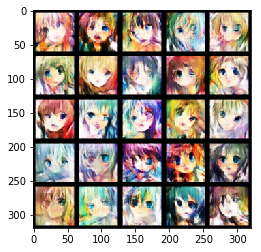

Epoch 5/5 - Batch 110/1039:  Discriminator loss = 1.4626  Generator loss = 0.5430
Epoch 5/5 - Batch 120/1039:  Discriminator loss = 1.8279  Generator loss = 0.2959
Epoch 5/5 - Batch 130/1039:  Discriminator loss = 1.1976  Generator loss = 1.6995
Epoch 5/5 - Batch 140/1039:  Discriminator loss = 1.9660  Generator loss = 0.2597
Epoch 5/5 - Batch 150/1039:  Discriminator loss = 1.0196  Generator loss = 1.1515
Epoch 5/5 - Batch 160/1039:  Discriminator loss = 1.5894  Generator loss = 0.3672
Epoch 5/5 - Batch 170/1039:  Discriminator loss = 2.3215  Generator loss = 0.2206
Epoch 5/5 - Batch 180/1039:  Discriminator loss = 1.2495  Generator loss = 2.0513
Epoch 5/5 - Batch 190/1039:  Discriminator loss = 1.4550  Generator loss = 0.4635
Epoch 5/5 - Batch 200/1039:  Discriminator loss = 2.0518  Generator loss = 0.2534


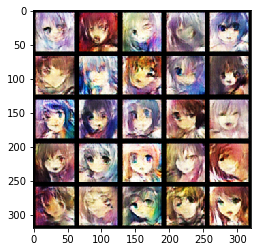

Epoch 5/5 - Batch 210/1039:  Discriminator loss = 1.1226  Generator loss = 1.6422
Epoch 5/5 - Batch 220/1039:  Discriminator loss = 1.8264  Generator loss = 2.6916
Epoch 5/5 - Batch 230/1039:  Discriminator loss = 1.0072  Generator loss = 0.9085
Epoch 5/5 - Batch 240/1039:  Discriminator loss = 1.8225  Generator loss = 0.3253
Epoch 5/5 - Batch 250/1039:  Discriminator loss = 1.2507  Generator loss = 1.1418
Epoch 5/5 - Batch 260/1039:  Discriminator loss = 1.8692  Generator loss = 0.2904
Epoch 5/5 - Batch 270/1039:  Discriminator loss = 1.1073  Generator loss = 0.9075
Epoch 5/5 - Batch 280/1039:  Discriminator loss = 1.4625  Generator loss = 1.4836
Epoch 5/5 - Batch 290/1039:  Discriminator loss = 1.5748  Generator loss = 0.3777
Epoch 5/5 - Batch 300/1039:  Discriminator loss = 1.4288  Generator loss = 0.4446


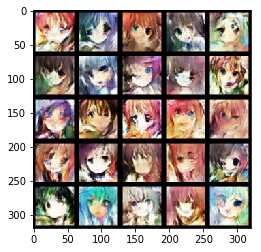

Epoch 5/5 - Batch 310/1039:  Discriminator loss = 1.4413  Generator loss = 0.4609
Epoch 5/5 - Batch 320/1039:  Discriminator loss = 1.7983  Generator loss = 0.3313
Epoch 5/5 - Batch 330/1039:  Discriminator loss = 0.9507  Generator loss = 1.1971
Epoch 5/5 - Batch 340/1039:  Discriminator loss = 1.0285  Generator loss = 1.0906
Epoch 5/5 - Batch 350/1039:  Discriminator loss = 1.4546  Generator loss = 0.4649
Epoch 5/5 - Batch 360/1039:  Discriminator loss = 0.8941  Generator loss = 1.2166
Epoch 5/5 - Batch 370/1039:  Discriminator loss = 1.5173  Generator loss = 0.4499
Epoch 5/5 - Batch 380/1039:  Discriminator loss = 1.2718  Generator loss = 0.5997
Epoch 5/5 - Batch 390/1039:  Discriminator loss = 1.5352  Generator loss = 3.3916
Epoch 5/5 - Batch 400/1039:  Discriminator loss = 1.0926  Generator loss = 0.9071


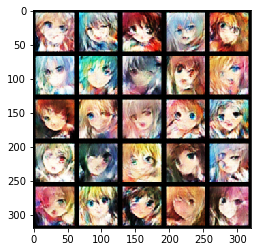

Epoch 5/5 - Batch 410/1039:  Discriminator loss = 1.2043  Generator loss = 1.7739
Epoch 5/5 - Batch 420/1039:  Discriminator loss = 2.2502  Generator loss = 3.9138
Epoch 5/5 - Batch 430/1039:  Discriminator loss = 1.1050  Generator loss = 1.8840
Epoch 5/5 - Batch 440/1039:  Discriminator loss = 0.9824  Generator loss = 0.9301
Epoch 5/5 - Batch 450/1039:  Discriminator loss = 1.6694  Generator loss = 0.3935
Epoch 5/5 - Batch 460/1039:  Discriminator loss = 1.3965  Generator loss = 0.5591
Epoch 5/5 - Batch 470/1039:  Discriminator loss = 1.6197  Generator loss = 0.4386
Epoch 5/5 - Batch 480/1039:  Discriminator loss = 1.0648  Generator loss = 0.9078
Epoch 5/5 - Batch 490/1039:  Discriminator loss = 1.5577  Generator loss = 0.4127
Epoch 5/5 - Batch 500/1039:  Discriminator loss = 1.7747  Generator loss = 0.3690


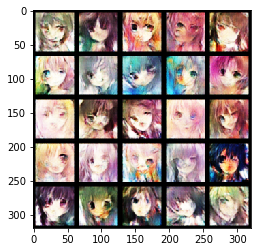

Epoch 5/5 - Batch 510/1039:  Discriminator loss = 1.4449  Generator loss = 0.4665
Epoch 5/5 - Batch 520/1039:  Discriminator loss = 1.2154  Generator loss = 1.8045
Epoch 5/5 - Batch 530/1039:  Discriminator loss = 2.5383  Generator loss = 0.1685
Epoch 5/5 - Batch 540/1039:  Discriminator loss = 1.0434  Generator loss = 0.9192
Epoch 5/5 - Batch 550/1039:  Discriminator loss = 1.1312  Generator loss = 0.9252
Epoch 5/5 - Batch 560/1039:  Discriminator loss = 1.0167  Generator loss = 0.8922
Epoch 5/5 - Batch 570/1039:  Discriminator loss = 0.8140  Generator loss = 1.4719
Epoch 5/5 - Batch 580/1039:  Discriminator loss = 1.0089  Generator loss = 1.2027
Epoch 5/5 - Batch 590/1039:  Discriminator loss = 1.4183  Generator loss = 0.5204
Epoch 5/5 - Batch 600/1039:  Discriminator loss = 1.2415  Generator loss = 0.6672


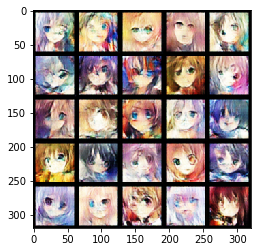

Epoch 5/5 - Batch 610/1039:  Discriminator loss = 1.6442  Generator loss = 0.3998
Epoch 5/5 - Batch 620/1039:  Discriminator loss = 0.9356  Generator loss = 1.0420
Epoch 5/5 - Batch 630/1039:  Discriminator loss = 1.2527  Generator loss = 1.6640


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25
conv_dim = 64


epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, '*.jpg')),img_size=IMG_SIZE)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode )